# 1. Exploratory Data Analysis

In this notebook, we perform an exploratory analysis of the Food-101 dataset, which serves as the foundation for all subsequent experiments in this project.
Before training any model, it is essential to understand the characteristics, structure, and potential irregularities of the data. This exploration provides the empirical context necessary to make informed modelling and preprocessing decisions.

## 1.1 Overview

In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from src.notebook.eda_utils import *
from src.data import read_splits, build_transforms, make_datasets

from PIL import Image
import torch
from torchvision import models, transforms

data_dir = os.path.join("data","food-101")
results_dir = "artifacts"
epoch_dir = os.path.join(results_dir, "per_epoch")
ckpt_dir = os.path.join(results_dir, "checkpoints")
image_dir = os.path.join(data_dir, "images")
meta_dir = os.path.join(data_dir, "meta")
img_size = 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 3

train_list, val_list = read_splits(meta_dir)
train_tf, val_tf = build_transforms(img_size)
train_ds, val_ds, classes = make_datasets(image_dir, train_list, val_list, train_tf, val_tf)

print(f"train: {len(train_ds)}  test/val: {len(val_ds)}  classes: {len(classes)}")

train: 75750  test/val: 25250  classes: 101


The Food-101 dataset is a large-scale image collection designed for fine-grained food recognition. It contains 101,000 images distributed across 101 distinct food categories, with each class comprising 750 training and 250 testing images. The images are highly diverse, collected from real-world sources, and therefore exhibit significant variability in lighting conditions, backgrounds, and presentation styles. This diversity makes the dataset a realistic benchmark for evaluating visual classification systems.

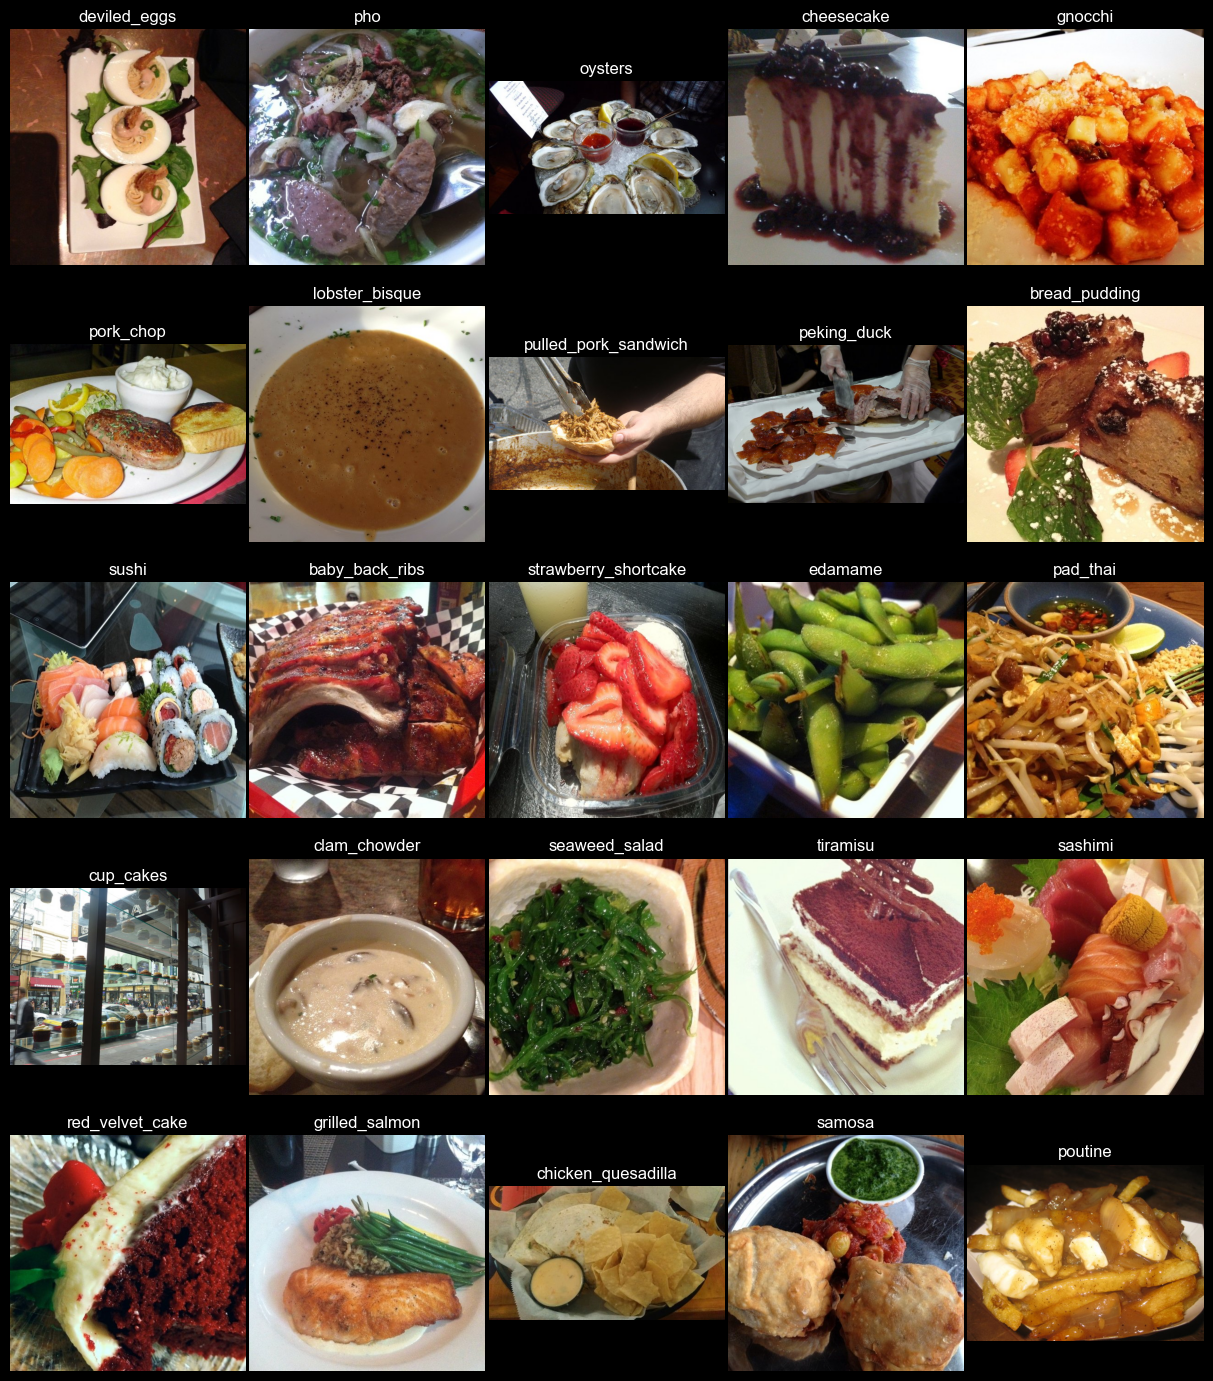

In [2]:
random.seed(3)
sample_paths = sample_distinct_classes(train_list, 25, data_dir)
show_grid(sample_paths, ncols=5, title_fontsize=12, figsize=(12, 14))

## 1.2 Dimensions

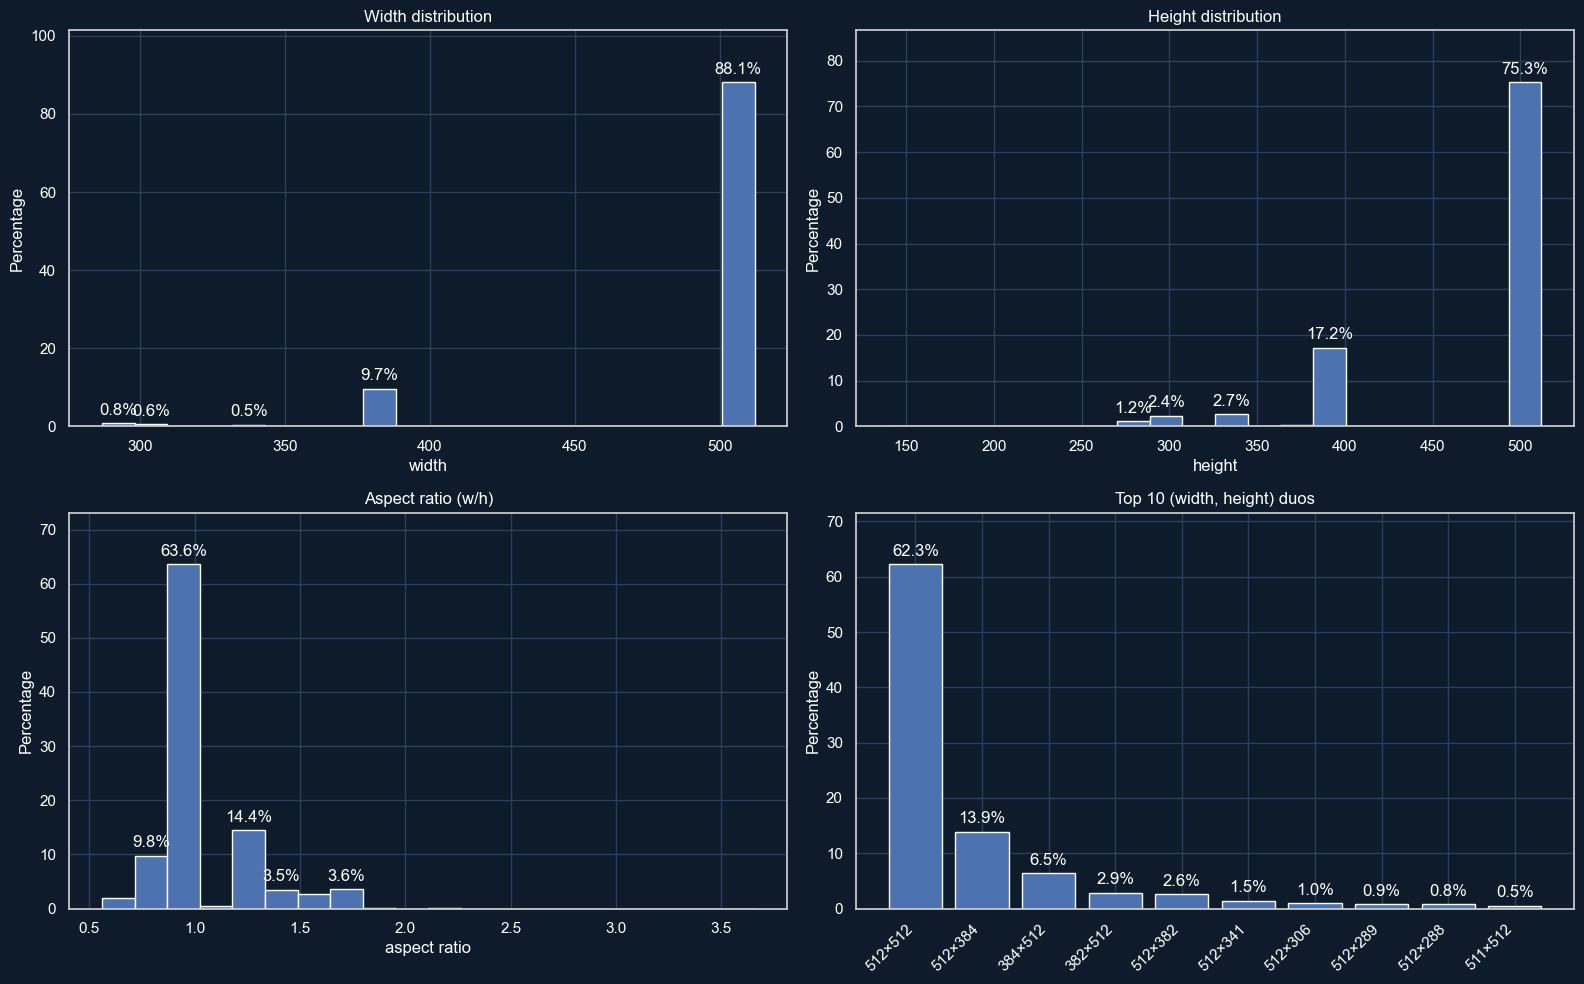

In [3]:
plot_image_size_stats(image_dir, train_list, val_list)

The dataset is strongly dominated by 512-pixel widths (≈88%) and 512-pixel heights (≈75%), so the modal size is 512×512 and accounts for the majority of samples. The aspect-ratio histogram confirms a strong peak at 1.0 (≈63%), with a secondary mode near 1.5 (≈21%) and a smaller cluster below 0.7 (≈11%), indicating a mixture of square, tall and wide images. The top-10 (width,height) pairs are heavily concentrated in a few combinations: 512×512 (≈62%), 512×384 (≈15%), and 384×512 (≈7%), with remaining pairs each below a few percent. These plots show overall homogeneity in resolution but non-negligible aspect-ratio diversity and a long tail of uncommon size tuples, which explain the observed intra-class visual variability.

## 1.3 Clusterization

To better understand how the dataset is organized in a high-dimensional representation space, we extract visual embeddings from a pretrained ResNet-50 model and project them onto two dimensions using t-SNE.

This approach allows us to observe how images from different food categories cluster when represented by generic visual features learned on ImageNet. Well-separated clusters indicate that the categories possess distinctive visual characteristics, while overlapping regions suggest higher inter-class similarity or visual ambiguity.
For clarity and computational efficiency, we use a small balanced subset of the dataset, sampling a limited number of images from ten random classes.

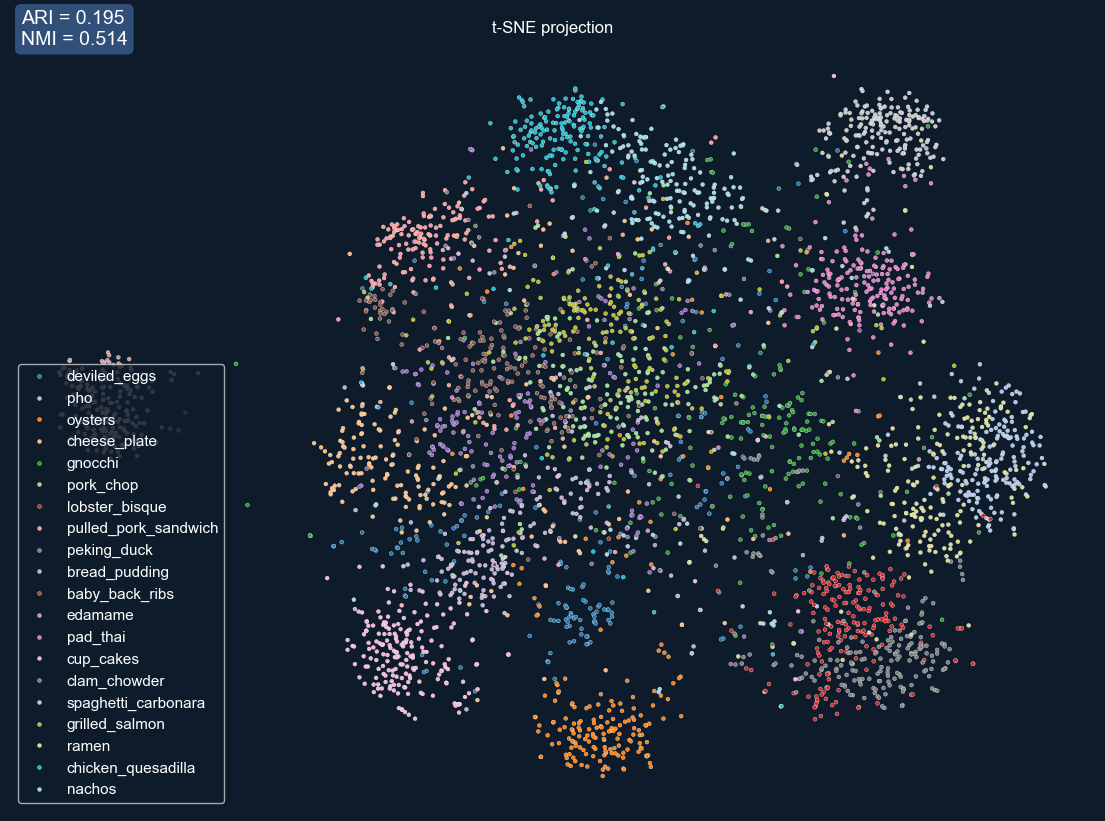

In [7]:
mode = "sample"                # "sample" or "full"
model_variant = "sequential"   # "sequential" or "identity"

pil_t, imgfolder_t, imagenet_norm = get_transforms(img_size=img_size)
ds = make_imagefolder(image_dir, imgfolder_t)
model = build_model(variant=model_variant, device=device, weights=models.ResNet50_Weights.DEFAULT)

res = run_embedding_pipeline(
    mode="sample", ds=ds, model=model,
    pil_transform=pil_t, imagenet_norm=imagenet_norm, 
    sample_num_classes=20, sample_per_class=200, random_seed=3, pca_before_tsne=False
)

X, y, labels, Z = res["X"], res["y"], res["labels"], res["Z"]

# run k-means diagnostics only for sufficiently large X
if X.shape[0] >= 1000:
    clusters, ari, nmi = run_kmeans_metrics(X if X.shape[1] else X, y, k_clusters=101, kmeans_batch=1024, random_seed=random_seed)

plt.figure(figsize=(14,10))
ax = plt.gca()
sns.scatterplot(x=Z[:,0], y=Z[:,1], hue=labels if mode=="sample" else y, s=8, palette="tab20", legend="full")
if ari is not None and nmi is not None:
    text = f"ARI = {ari:.3f}\nNMI = {nmi:.3f}"
    ax.text(
        0.01, 0.99, text,transform=ax.transAxes,ha="left", va="bottom",fontsize=14, color="white",
        bbox=dict(boxstyle="round,pad=0.3",alpha=0.6, ec="none"),
    )
plt.title("t-SNE projection")
plt.axis("off")
plt.show()

The projection shows distinct clusters for certain classes and a dense overlapping core for others. Some categories form compact, isolated groups evidence of low intra-class variation and strong visual distinctiveness in pretrained ResNet features.
The central region mixes multiple labels, indicating high inter-class similarity where different dishes share color, texture, or presentation cues.
Diffuse or elongated clusters suggest large intra-class diversity, while isolated points may correspond to outliers or atypical samples.

Overall, the t-SNE plot demonstrates that ImageNet features already encode useful structure: several food types are clearly separable, though others require fine-tuning to achieve better discrimination.

The **Adjusted Rand Index (ARI)** measures how well the unsupervised clusters match the true labels after correcting for chance, and the **Normalized Mutual Information (NMI)** measures how much information the clusters share with the true labels on a 0 to 1 scale.

With an ARI of 0.195, the agreement between the unsupervised clusters and the ground-truth classes is limited, which is expected because the model has not been adapted to the Food-101 dataset. The NMI of 0.514 indicates that there is still a moderate amount of shared structure: the pretrained features capture broad visual similarities, but they do not align tightly with the actual class boundaries. This level of correspondence is typical for generic ImageNet features applied to a fine-grained dataset without tuning.

## 1.4 Relationship between categories

To complement the two-dimensional t-SNE visualization, we next examine the relationships between food categories at the class level. Using the feature centroids computed from the pretrained ResNet-50 embeddings, we measure the cosine similarity between every pair of classes and construct a hierarchical dendrogram that summarizes these inter-class distances. This representation provides a global view of the dataset’s visual taxonomy, grouping together foods that share common textures, colors, or shapes. Closely linked branches correspond to visually similar categories, while distant ones reflect distinctive visual identities. The resulting hierarchy offers valuable insight into how the model perceives semantic proximity between different dishes in the embedding space.

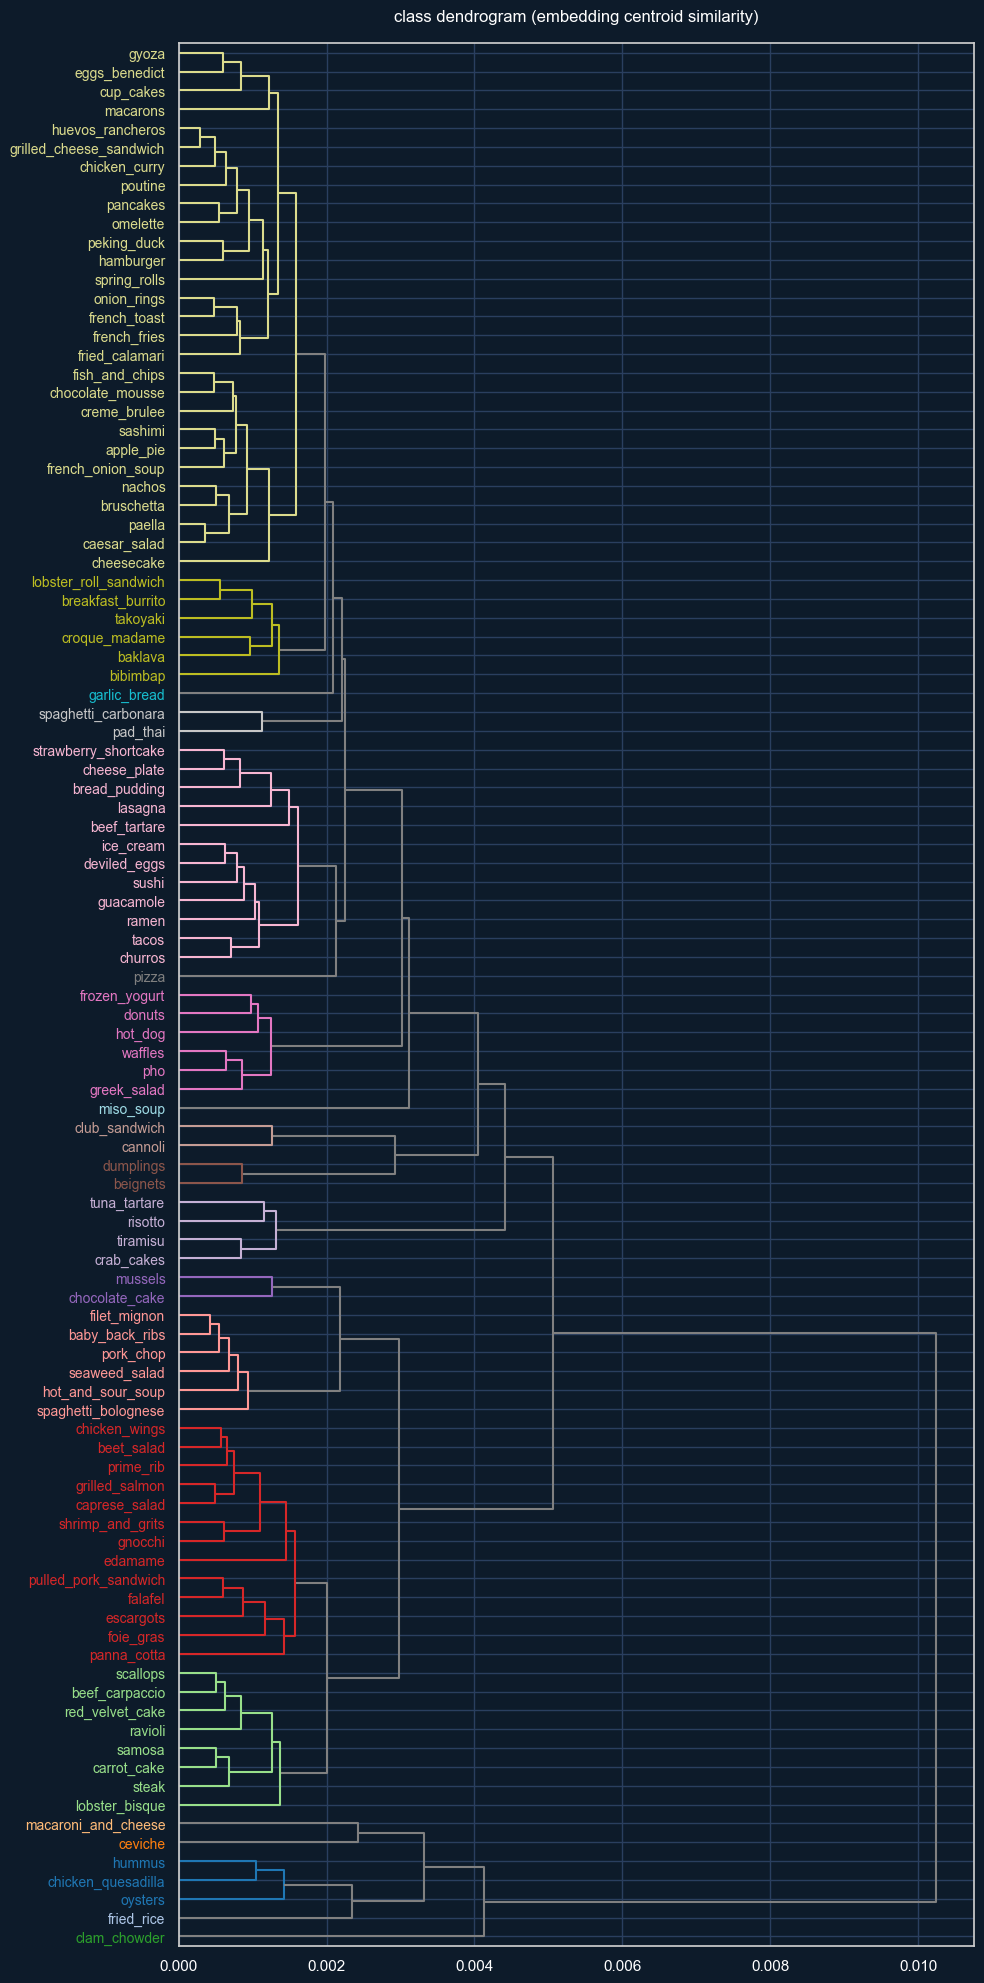

In [6]:
# centroid embedding function wrapper
embed_fn = lambda imgs: embed_batch_from_tensor(imgs, model=model, imagenet_norm=imagenet_norm,
                                                model_variant=model_variant, device=device, normalize_embeddings=False)

centroids = compute_class_centroids(source_ds=(chosen_ds if mode=="full" and 'chosen_ds' in globals() else ds),
                                   classes=ds.classes,
                                   embed_batch_fn=embed_fn,
                                   imagenet_norm=imagenet_norm,
                                   centroid_samples_per_class=64,
                                   batch_size=256,
                                   model_variant=model_variant)

zlink = compute_linkage_from_centroids(centroids, method="average")
cluster_assign = assign_flat_clusters(zlink, n_dendro_clusters=20)
class_to_color, leaf_cluster, hex_palette = build_class_color_mapping(ds.classes, cluster_assign, n_dendro_clusters=20)
link_color = make_link_color_func(zlink, n=len(ds.classes), leaf_cluster=leaf_cluster, hex_palette=hex_palette)
plot_vertical_dendrogram(zlink, ds.classes, class_to_color, link_color, figsize=(10,20))


The dendrogram provides a high-level view of how the pretrained ResNet-50 model, using transfer-learned features, perceives relationships between food categories based on visual appearance. Classes that appear close together share similar visual features in this generic embedding space.

Several coherent regions emerge. Breakfast-related items such as pancakes, waffles, and French toast tend to cluster near each other, reflecting similar textures and colors. Fried or fast-food dishes including hamburgers, fries, and onion rings form another region. Sweet desserts such as cupcakes, cheesecakes, and tiramisu are grouped together, which is consistent with their common color tones and presentation styles. Dishes with meats such as steak, pork chop, and ribs appear in a broader cluster toward the lower part of the tree, often near other protein-rich meals like grilled salmon or shrimp and grits.

At the opposite end, lighter or fresher dishes such as salads, sushi, and ceviche occupy another section, which aligns with their more vivid colors and less dense compositions. Soup-like dishes such as miso soup and clam chowder also show proximity, suggesting the model captures broad appearance cues such as bowl-based presentation.

Overall, the structure indicates that the network organizes dishes primarily by dominant visual and presentation patterns such as color palette, texture, and plating style. This reflects how a vision model pretrained on natural images interprets the dataset: it groups foods not by recipe or ingredient but by shared visual characteristics. We will revisit this analysis in the next notebook using fully fine-tuned models to observe how the learned representations evolve on the target dataset.

## 1.5 Conclusion

This exploratory analysis has provided a detailed overview of the Food-101 dataset from both a raw and representational perspective. The dimensional study revealed a predominance of 512×512 square images, confirming a relatively consistent resolution across samples with limited aspect-ratio variability. The t-SNE and dendrogram analyses, based on pretrained ResNet-50 embeddings, showed that many food categories already form coherent visual clusters, while others overlap significantly due to shared textures, colors, or presentation styles. Together, these observations illustrate the dataset’s balance between homogeneity and diversity, sufficient structure for transfer learning, yet enough variability to pose a genuine fine-grained recognition challenge.

In the following [Models notebook](2_models.ipynb), we build on these findings by training and comparing multiple deep learning architectures. The insights gained here will guide model selection, preprocessing choices, and the evaluation of representation quality in subsequent experiments.